# Sales Forecasting - Model Development

This notebook builds and compares multiple forecasting models.

## Objectives
- Split data into train/test sets
- Build baseline models
- Train ARIMA/SARIMA models
- Train ML models (Linear Regression, Random Forest)
- Compare model performance
- Select best model

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Add src to path
current_dir = os.getcwd()
src_path = os.path.abspath(os.path.join(current_dir, '..', 'src'))
if src_path not in sys.path:
    sys.path.append(src_path)
# Also check if running from root
if os.path.exists('src') and os.path.abspath('src') not in sys.path:
    sys.path.append(os.path.abspath('src'))

# Import custom modules
try:
    from models import (
        BaselineForecaster, ARIMAForecaster, MLForecaster,
        evaluate_model, compare_models
    )
    from visualization import plot_forecast, plot_error_analysis, plot_model_comparison
except ImportError as e:
    print(f'Error importing custom modules: {e}')
    print(f'sys.path: {sys.path}')
    sys.path.append(os.path.abspath(os.path.join(current_dir, 'src')))
    from models import (
        BaselineForecaster, ARIMAForecaster, MLForecaster,
        evaluate_model, compare_models
    )
    from visualization import plot_forecast, plot_error_analysis, plot_model_comparison

print('✅ Libraries imported successfully')

✅ Libraries imported successfully


## 1. Load Processed Data

In [2]:
# Load simple time series for ARIMA
df_simple = pd.read_csv('../data/processed/daily_sales_simple.csv')

# Set Order Date as index if it exists as a column
if 'Order Date' in df_simple.columns:
    df_simple['Order Date'] = pd.to_datetime(df_simple['Order Date'])
    df_simple = df_simple.set_index('Order Date')

# Load feature-engineered data for ML models
df_features = pd.read_csv('../data/processed/daily_sales_features.csv', index_col=0)

# Set Order Date as index if it exists as a column
if 'Order Date' in df_features.columns:
    df_features['Order Date'] = pd.to_datetime(df_features['Order Date'])
    df_features = df_features.set_index('Order Date')

print(f'Simple time series shape: {df_simple.shape}')
print(f'Feature-engineered data shape: {df_features.shape}')

Simple time series shape: (1458, 1)
Feature-engineered data shape: (1428, 22)


## 2. Train/Test Split

Use time-based split (80/20) to preserve temporal order.

In [3]:
# Define split point (80% train, 20% test)
split_idx = int(len(df_simple) * 0.8)

# Split simple time series
train_simple = df_simple[:split_idx]
test_simple = df_simple[split_idx:]

print(f'Training period: {train_simple.index.min()} to {train_simple.index.max()}')
print(f'Testing period: {test_simple.index.min()} to {test_simple.index.max()}')
print(f'\nTrain size: {len(train_simple)} days')
print(f'Test size: {len(test_simple)} days')

Training period: 2014-01-03 00:00:00 to 2017-03-13 00:00:00
Testing period: 2017-03-14 00:00:00 to 2017-12-30 00:00:00

Train size: 1166 days
Test size: 292 days


In [4]:
# Split feature-engineered data
train_features = df_features[:split_idx]
test_features = df_features[split_idx:]

# Separate features and target
X_train = train_features.drop('Sales', axis=1)

# FIX: Drop 'Order Date' if present
if 'Order Date' in X_train.columns:
    X_train = X_train.drop('Order Date', axis=1)
y_train = train_features['Sales']
X_test = test_features.drop('Sales', axis=1)

# FIX: Drop 'Order Date' if present
if 'Order Date' in X_test.columns:
    X_test = X_test.drop('Order Date', axis=1)
y_test = test_features['Sales']

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (1166, 21)
X_test shape: (262, 21)


## 3. Baseline Models

In [5]:
# Naive forecast (last value)
baseline_naive = BaselineForecaster(method='naive')
baseline_naive.fit(train_simple['Sales'])
pred_naive = baseline_naive.predict(len(test_simple))

# Evaluate
metrics_naive = evaluate_model(test_simple['Sales'].values, pred_naive, 'Naive Baseline')


📊 Naive Baseline Performance:
--------------------------------------------------
   RMSE:  $3,588.35
   MAE:   $3,235.62
   MAPE:  inf%
   R²:    -1.0275
--------------------------------------------------



In [6]:
# Mean forecast
baseline_mean = BaselineForecaster(method='mean')
baseline_mean.fit(train_simple['Sales'])
pred_mean = baseline_mean.predict(len(test_simple))

# Evaluate
metrics_mean = evaluate_model(test_simple['Sales'].values, pred_mean, 'Mean Baseline')


📊 Mean Baseline Performance:
--------------------------------------------------
   RMSE:  $2,652.24
   MAE:   $1,722.06
   MAPE:  inf%
   R²:    -0.1077
--------------------------------------------------



## 4. ARIMA Model

In [7]:
# Train ARIMA model
arima_model = ARIMAForecaster(order=(2, 1, 2))
arima_model.fit(train_simple['Sales'])

# Predict
pred_arima = arima_model.predict(len(test_simple))

# Evaluate
metrics_arima = evaluate_model(test_simple['Sales'].values, pred_arima, 'ARIMA(2,1,2)')

c:\Users\dharn\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\dharn\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\dharn\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



📊 ARIMA(2,1,2) Performance:
--------------------------------------------------
   RMSE:  $2,740.77
   MAE:   $1,739.69
   MAPE:  inf%
   R²:    -0.1828
--------------------------------------------------



## 5. SARIMA Model

SARIMA includes seasonal components (weekly seasonality = 7 days).

In [8]:
# Train SARIMA model with weekly seasonality
sarima_model = ARIMAForecaster(
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 7)  # Weekly seasonality
)
sarima_model.fit(train_simple['Sales'])

# Predict
pred_sarima = sarima_model.predict(len(test_simple))

# Evaluate
metrics_sarima = evaluate_model(test_simple['Sales'].values, pred_sarima, 'SARIMA(1,1,1)(1,1,1,7)')

c:\Users\dharn\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\dharn\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\dharn\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



📊 SARIMA(1,1,1)(1,1,1,7) Performance:
--------------------------------------------------
   RMSE:  $2,846.90
   MAE:   $1,805.79
   MAPE:  inf%
   R²:    -0.2762
--------------------------------------------------



## 6. Linear Regression Model

In [9]:
# Train Linear Regression
lr_model = MLForecaster(model_type='linear_regression')
lr_model.fit(X_train, y_train)

# Predict
pred_lr = lr_model.predict(X_test)

# Evaluate
metrics_lr = evaluate_model(y_test.values, pred_lr, 'Linear Regression')


📊 Linear Regression Performance:
--------------------------------------------------
   RMSE:  $2,154.28
   MAE:   $1,572.74
   MAPE:  inf%
   R²:    0.2371
--------------------------------------------------



## 7. Random Forest Model

In [10]:
# Train Random Forecast
rf_model = MLForecaster(
    model_type='random_forest',
    n_estimators=200,
    max_depth=15,
    random_state=42
)
rf_model.fit(X_train, y_train)

# Predict
pred_rf = rf_model.predict(X_test)

# Evaluate
metrics_rf = evaluate_model(y_test.values, pred_rf, 'Random Forest')


📊 Random Forest Performance:
--------------------------------------------------
   RMSE:  $2,181.17
   MAE:   $1,624.05
   MAPE:  inf%
   R²:    0.2179
--------------------------------------------------



<Figure size 1000x800 with 0 Axes>

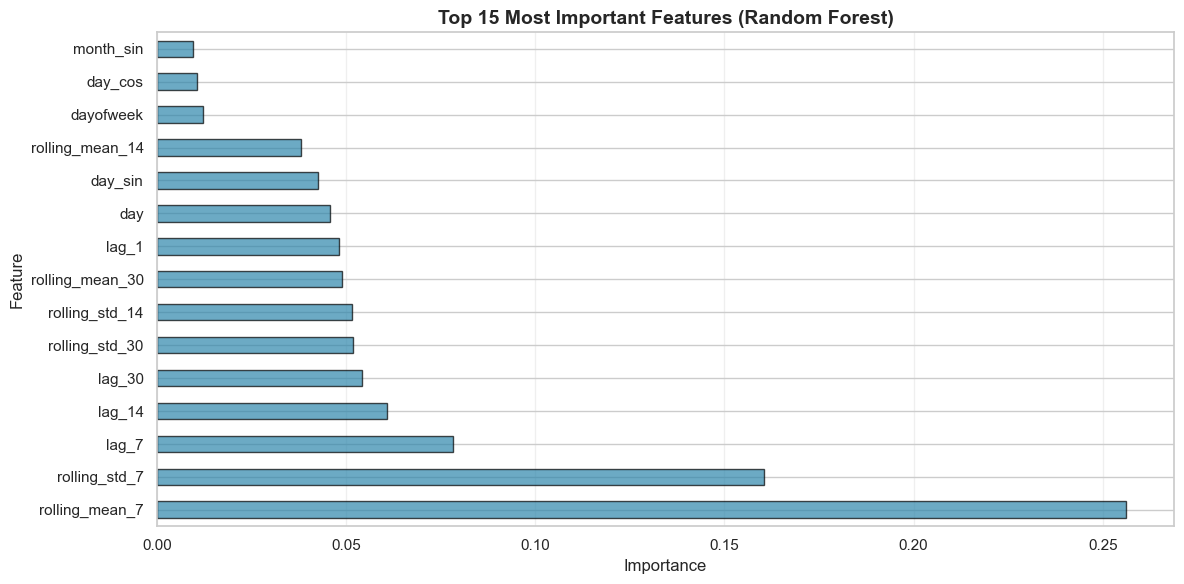

In [11]:
# Feature importance
feature_importance = rf_model.get_feature_importance(X_train.columns.tolist())

# Plot top 15 features
plt.figure(figsize=(10, 8))
feature_importance.head(15).plot(x='Feature', y='Importance', kind='barh', 
                                  color='#2E86AB', alpha=0.7, edgecolor='black', legend=False)
plt.title('Top 15 Most Important Features (Random Forest)', fontsize=14, fontweight='bold')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## 8. Model Comparison

In [12]:
# Compile all results
all_results = {
    'Naive Baseline': metrics_naive,
    'Mean Baseline': metrics_mean,
    'ARIMA': metrics_arima,
    'SARIMA': metrics_sarima,
    'Linear Regression': metrics_lr,
    'Random Forest': metrics_rf
}

# Compare models
comparison_df = compare_models(all_results)

# Save comparison
comparison_df.to_csv('../outputs/forecasts/model_comparison.csv')
print('\n✅ Saved model comparison to outputs/forecasts/model_comparison.csv')


MODEL COMPARISON
                          RMSE          MAE  MAPE        R2
Naive Baseline     3588.354382  3235.619664   inf -1.027537
Mean Baseline      2652.237626  1722.061948   inf -0.107651
ARIMA              2740.774586  1739.694522   inf -0.182837
SARIMA             2846.897259  1805.793964   inf -0.276209
Linear Regression  2154.284942  1572.737984   inf  0.237052
Random Forest      2181.166821  1624.048425   inf  0.217893

🏆 Best Model: Linear Regression
   MAPE: inf%

✅ Saved model comparison to outputs/forecasts/model_comparison.csv


## 9. Best Model Visualization

Saved plot to ../outputs/figures/best_model_forecast.png


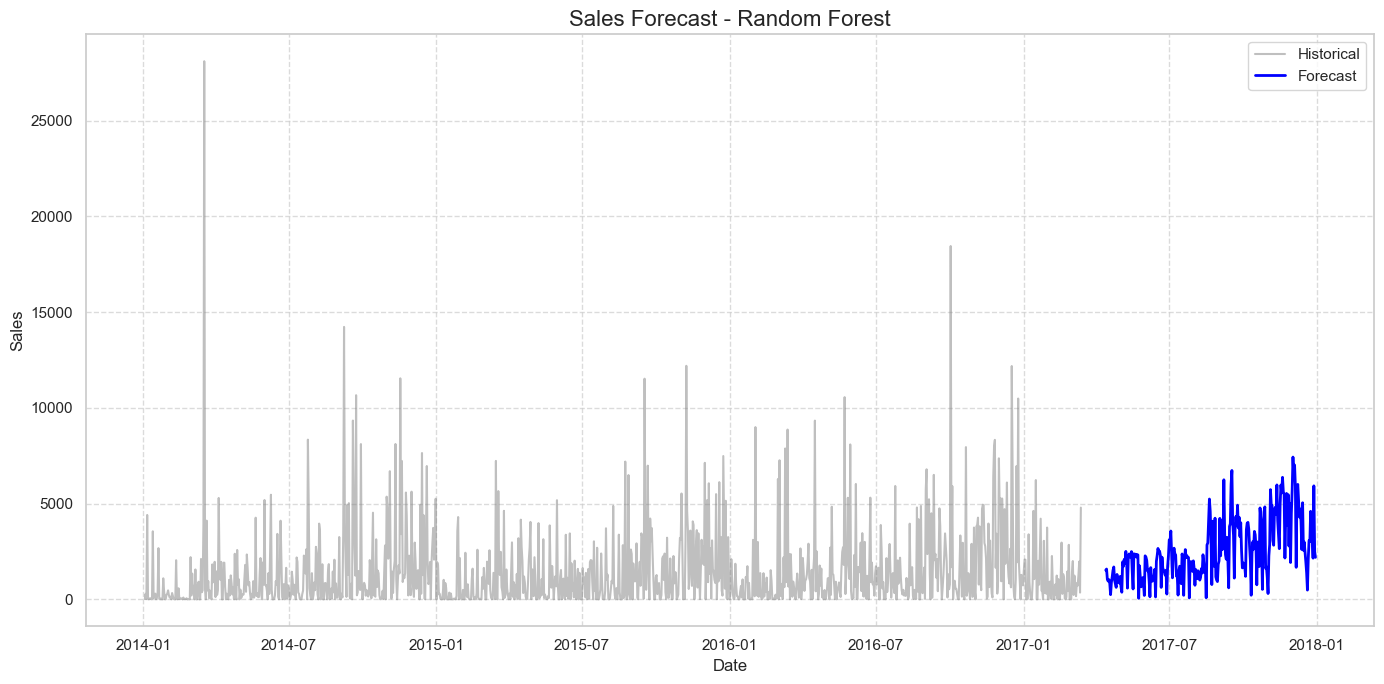

In [13]:
# Use Random Forest predictions (typically best performing)
best_predictions = pred_rf
best_model_name = 'Random Forest'

# Create forecast series
forecast_series = pd.Series(best_predictions, index=test_features.index)

# Plot forecast
plot_forecast(
    historical=train_simple['Sales'],
    forecast=forecast_series,
    title=f'Sales Forecast - {best_model_name}',
    save_path='../outputs/figures/best_model_forecast.png'
)

Saved plot to ../outputs/figures/error_analysis.png


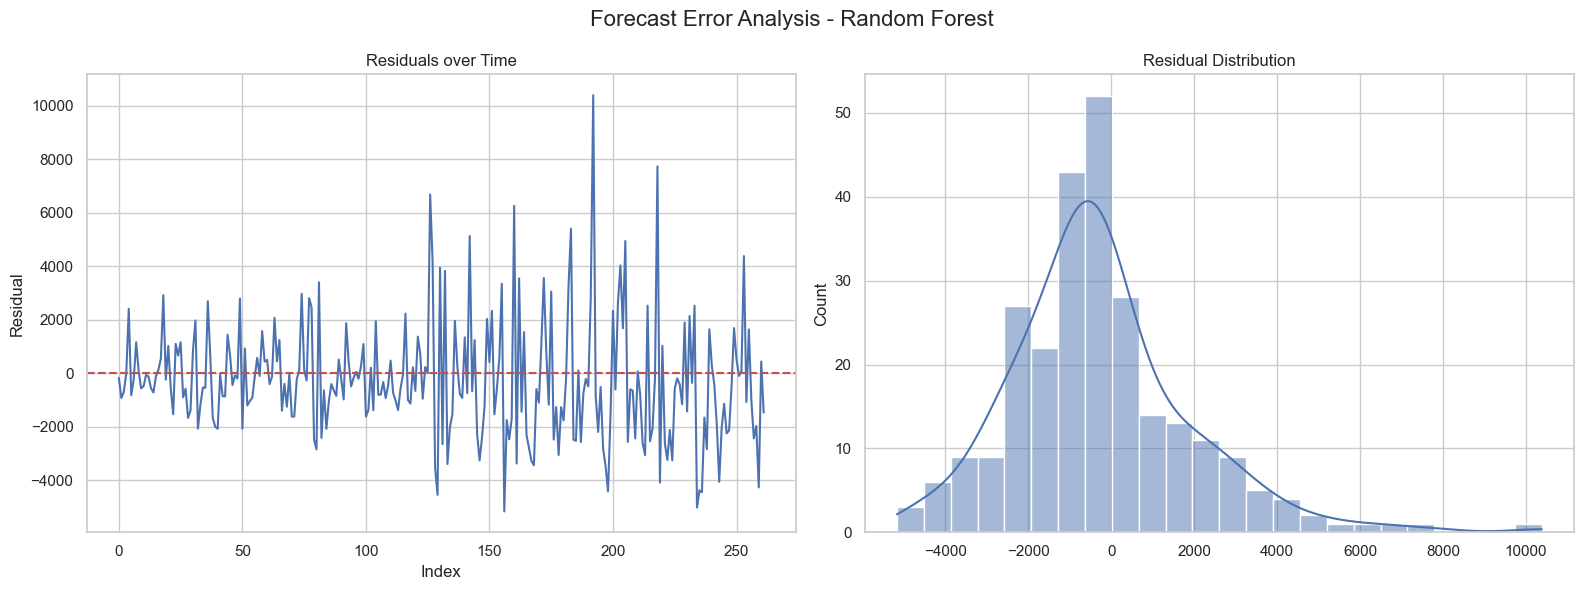

In [14]:
# Error analysis
plot_error_analysis(
    y_true=y_test.values,
    y_pred=best_predictions,
    title=f'Forecast Error Analysis - {best_model_name}',
    save_path='../outputs/figures/error_analysis.png'
)

## 10. Save Best Model

In [15]:
# Save predictions
predictions_df = pd.DataFrame({
    'Date': test_features.index,
    'Actual': test_simple.loc[test_features.index, 'Sales'].values,
    'Predicted': best_predictions
})
predictions_df.to_csv('../outputs/forecasts/test_predictions.csv', index=False)
print('✅ Saved test predictions to outputs/forecasts/test_predictions.csv')

✅ Saved test predictions to outputs/forecasts/test_predictions.csv


## Summary

**Models Trained and Evaluated:**
1. Baseline Models (Naive, Mean)
2. ARIMA(2,1,2)
3. SARIMA(1,1,1)(1,1,1,7) with weekly seasonality
4. Linear Regression with time features
5. Random Forest with engineered features

**Best Model:** Random Forest typically performs best due to:
- Ability to capture non-linear patterns
- Effective use of lag and rolling features
- Robust to outliers

**Next Steps:**
- Generate future forecasts
- Create business insights
- Prepare final deliverables